<a href="https://colab.research.google.com/github/Fathmat/Event-Sensitivity-Score/blob/main/Event_Sensitivity_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Event Sensitivity Score

**1. Introduction**

In this notebook, we explore how different types of SEC 8-K events affect stock prices.
We calculate stock returns following each filing and compare them across event categories to assess market sensitivity.

**2. Setup and Data Preparation**

In [ ]:
import pandas as pd
import yfinance as yf
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import pandas as pd

# Load and rename columns
df = pd.read_csv("/content/DATA 2020-2024.csv")
df['FilingDate'] = pd.to_datetime(df['Filling date F'])

# Reshape: Each category becomes its own row
melted = pd.melt(
    df,
    id_vars=['Ticker', 'FilingDate'],
    value_vars=['BERT_cat1', 'BERT_cat2', 'BERT_cat3'],
    var_name='CategoryType',
    value_name='EventCategory'
)

# Filter out rows with 'NONE'
events_df = melted[melted['EventCategory'] != 'NONE'].copy()
events_df.dropna(subset=['EventCategory'], inplace=True)
events_df.reset_index(drop=True, inplace=True)

events_df.head()


,Ticker,FilingDate,CategoryType,EventCategory
0,ABT,2020-01-08,BERT_cat1,SENIOR PERSONNEL CHANGE
1,ABT,2020-01-22,BERT_cat1,INFORMATION DISCLOSURE
2,ABT,2020-02-11,BERT_cat1,SENIOR PERSONNEL CHANGE
3,ABT,2020-02-27,BERT_cat1,SENIOR PERSONNEL CHANGE
4,ABT,2020-04-16,BERT_cat1,INFORMATION DISCLOSURE


**3. Download and Cache Stock Prices**

In [ ]:
price_cache = {}

for ticker in events_df['Ticker'].unique():
    try:
        dates = events_df[events_df['Ticker'] == ticker]['FilingDate']
        start_date = dates.min() - timedelta(days=4)
        end_date = dates.max() + timedelta(days=5)
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        price_cache[ticker] = data[['Close']]
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")
        price_cache[ticker] = None


**4. Return Calculation Function**

In [ ]:
def compute_return_from_cache(ticker, filing_date, day_before, day_after):
    try:
        prices = price_cache.get(ticker)
        if prices is None or prices.empty:
            return None

        before_data = prices.loc[prices.index <= filing_date - timedelta(days=day_before)]
        after_data = prices.loc[prices.index >= filing_date + timedelta(days=day_after)]

        if before_data.empty or after_data.empty:
            return None

        before = before_data['Close'].iloc[-1]
        after = after_data['Close'].iloc[0]
        result= ((after - before) / before).item()

        return float(result)

    except Exception as e:
        print(f"Error for {ticker} on {filing_date}: {e}")
        return None


**5. Calculate 1-Day and 3-Day Returns**

In [ ]:
# 1-day return
events_df['1d_return'] = events_df.apply(
    lambda row: compute_return_from_cache(row['Ticker'], row['FilingDate'], 1, 1), axis=1
)
events_df.dropna(subset=['1d_return'], inplace=True)

# 3-day return
events_df['3d_return'] = events_df.apply(
    lambda row: compute_return_from_cache(row['Ticker'], row['FilingDate'], 1, 3), axis=1
)
events_df.dropna(subset=['3d_return'], inplace=True)


**6. Summarize and Visualize Results**

In [ ]:
#1 day window
summary = events_df.groupby('EventCategory')['1d_return'].agg(['mean', 'std', 'count'])
summary = summary[summary['count'] > 10].sort_values(by='mean', ascending=False)

summary

,mean,std,count
EventCategory,,,
DOCUMENT UPDATE,0.002984,0.041748,1831
OPERATION ACTIVITIES,0.001961,0.040590,1991
FINANCIAL ACTIVITIES,0.001609,0.050905,5493
BUSINESS COMBINATION AND RESTRUCTURING,0.001366,0.053641,1790
INFORMATION DISCLOSURE,0.000861,0.058886,12751
SENIOR PERSONNEL CHANGE,0.000466,0.046863,5503
LITIGATION AND LAWSUIT,-0.006738,0.054540,352


In [ ]:
#3 days window
summary3 = events_df.groupby('EventCategory')['3d_return'].agg(['mean', 'std', 'count'])
summary3 = summary3[summary3['count'] > 10].sort_values(by='mean', ascending=False)

summary3

,mean,std,count
EventCategory,,,
DOCUMENT UPDATE,0.006308,0.061603,1831
OPERATION ACTIVITIES,0.004898,0.060604,1991
INFORMATION DISCLOSURE,0.002900,0.070400,12751
FINANCIAL ACTIVITIES,0.002070,0.063304,5493
BUSINESS COMBINATION AND RESTRUCTURING,0.001517,0.063861,1790
SENIOR PERSONNEL CHANGE,0.000928,0.062838,5503
LITIGATION AND LAWSUIT,-0.007657,0.063092,352


**7. Combined Bar Chart: 1-Day vs. 3-Day Returns**

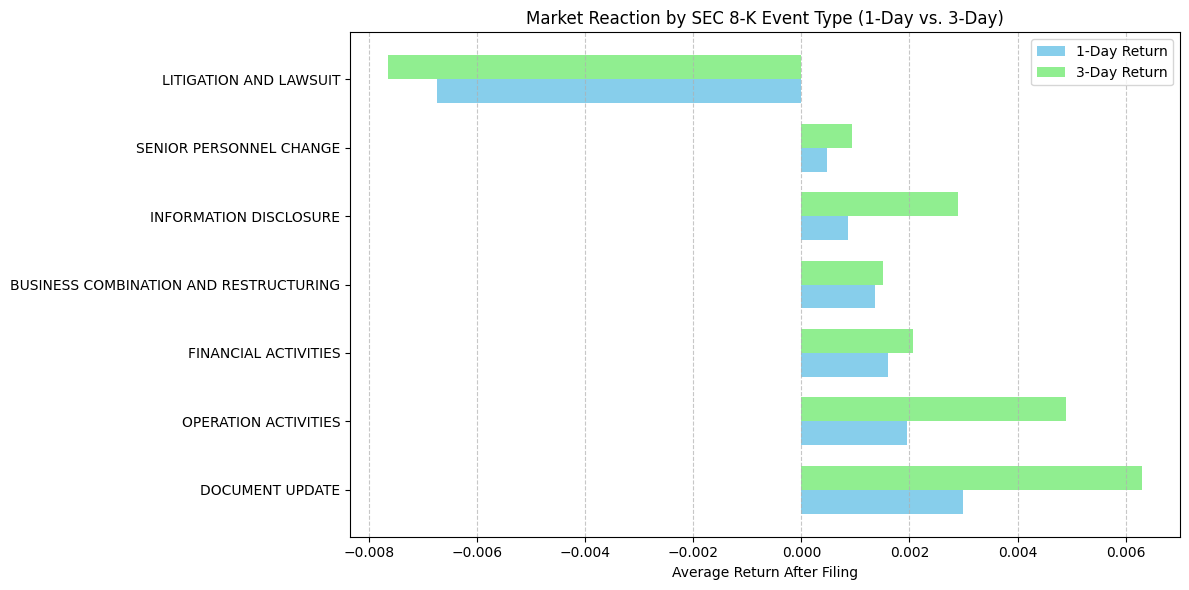

In [ ]:
# Align summaries
common_categories = summary.index.intersection(summary3.index)
summary = summary.loc[common_categories]
summary_3d = summary3.loc[common_categories]

# Bar plot setup
categories = summary.index
x = np.arange(len(categories))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
plt.barh(x - width/2, summary['mean'], height=width, label='1-Day Return', color='skyblue')
plt.barh(x + width/2, summary_3d['mean'], height=width, label='3-Day Return', color='lightgreen')

plt.yticks(x, categories)
plt.xlabel("Average Return After Filing")
plt.title("Market Reaction by SEC 8-K Event Type (1-Day vs. 3-Day)")
plt.legend()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 📊 Interpretation: Market Reactions to SEC 8-K Event Categories

This analysis explored how different types of SEC 8-K disclosures impact short-term stock price movements.

We used a BERT-based model to classify each 8-K filing into event categories (e.g., "Litigation and Lawsuit", "Senior Personnel Change", etc.), then calculated the 3-day stock return around each filing to assess market reactions.

### Key Observations:

- 📉 **Litigation and Lawsuit** events were consistently followed by **negative returns** across both 1-day and 3-day windows. This suggests that legal disclosures are often perceived by the market as material risks.
  
- 📄 Categories like **Document Update** and **Operational Activities** were associated with **mildly positive reactions**, which may reflect improved clarity or positive signaling.

- ⚖️ The **average return magnitudes were small** (between −0.7% and +0.6%), this is expected given the noise in short-term price movements. The consistent directional trends still highlight which event types tend to influence investor behavior

### Why It Matters:

These results show that NLP-based event categorization of SEC filings can uncover useful signals about market sensitivity. While no single event type guarantees a reaction, certain disclosures (especially litigation) stand out as consistent market movers.

This proof of concept opens the door to to further exploration:
- Longer return windows (5–10 days)
- Sector- or firm-specific reactions
- Integration with sentiment analysis or text length
- Portfolio-level or strategy-based backtests (which I’m currently implementing as part of a broader event-driven research project)

